# Intro

Machine learning can help astronomers sort big data recorded in space exploration.

**Gravitational Wave:**

Very simply,
`A gravitational wave is like ripples in space time. It is usually caused by some of the most violent and energetic processes in the Universe.`

They are invisible but incredibly fast. 

**Why we need to detect GW?**

Detecting and analyzing the information carried by gravitational waves is allowing us to observe the Universe in a way never before possible, providing astronomers and other scientists with their first glimpses of literally un-seeable wonders.
 When a gravitational wave passes by Earth, it squeezes and stretches space. LIGO can detect this squeezing and stretching. Each LIGO observatory has two “arms” that are each more than 2 miles (4 kilometers) long.
 
##### **above info collected via some very rough googling**
 
### Goal

The GW was first detected/seen when two blackholes merged into one big black whole back in Sept, 2015.

In this competition, our goal is to detect GW signals from the mergers of binary black holes.

I am going to document this process as I start with zero idea about any of these.

The folowing two kernels have been my overall inspiration to understand this whole task to my best capability. These are really well explained and worth mentioning.

- [kernel 1](https://www.kaggle.com/pranay1990/pranay-g2net-gw)
- [kernel 2](https://github.com/SiddharthPatel45/gravitational-wave-detection/blob/main/code/gw-detection-modelling.ipynb)
- [kernel 3](https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration/comments)

Thank you for sharing your work.

# Imports

In [1]:
!pip install -q nnAudio

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC

import librosa.display
import torch

# this is used for Contant Q Transform
from nnAudio.Spectrogram import CQT1992v2
from tensorflow.keras.applications import EfficientNetB0 as efn

2021-09-16 10:18:07.636069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Files

```
train: contains one npy file per observation.

test: we have to predict the probability whether or not the observation contains a gravitational wave.

training_labels: If associated signal contains a GW or not.
```

The waves detected by GW detectors have noises in output signals. So researchers need to find out if the output signal is only **noise** or **signal+noise**.


We are provided with a training set of time series data containing simulated gravitational wave measurements from a network of 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo). 

This problem is seen as a binary classification problem, if signal is detected or not. 
 

## Data Exploration

In [3]:
train_label_dataset = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_label_dataset.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [4]:
train_label_dataset.shape

(560000, 2)

when `target = 1` it means that the signal (GW) is present

<AxesSubplot:xlabel='target', ylabel='count'>

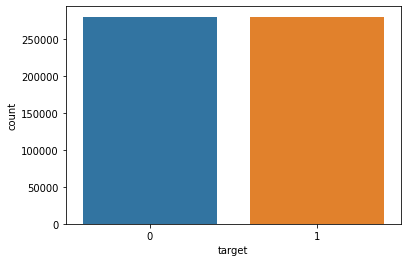

In [5]:
sns.countplot(data=train_label_dataset, x="target")

In [6]:
train_label_dataset['target'].value_counts()

0    280070
1    279930
Name: target, dtype: int64

Looking for null values:

In [7]:
train_label_dataset.isnull().sum() # no null

id        0
target    0
dtype: int64

In [8]:
train_path = glob('../input/g2net-gravitational-wave-detection/train/*/*/*/*')

There are 560,000 **.npy** files in the `train` set

In [9]:
len(train_path)

560000

If we want to take a took at how these data looks:

lets see how data at index 3 looks

In [10]:
explore_sample_3 = np.load(train_path[3])
explore_sample_3

array([[-4.91813710e-23, -7.05830975e-23, -4.32385900e-22, ...,
         6.26179817e-21,  6.43188118e-21,  6.66238270e-21],
       [ 8.74606391e-23,  4.45734626e-22,  6.40087700e-22, ...,
        -6.20618385e-21, -5.87733066e-21, -5.83612734e-21],
       [ 1.03456406e-21,  1.31619310e-21,  1.34011440e-21, ...,
        -1.65402703e-21, -1.24440865e-21, -1.25836288e-21]])

We can see that there are 3 rows to the data. This represents data extracted by 3 gravitational wave interferometers (LIGO Hanford, LIGO Livingston, and Virgo) respectively.

In [11]:
explore_sample_3.shape

(3, 4096)

each index of `explore_sample_3` has **4096** columns

In [12]:
print(len(explore_sample_3[0]), len(explore_sample_3[1]), len(explore_sample_3[2]))

4096 4096 4096


In [13]:
# just a tensor representation
tf.convert_to_tensor(explore_sample_3[0])

2021-09-16 10:19:45.662237: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 10:19:45.666218: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-16 10:19:45.712228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 10:19:45.712833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-16 10:19:45.712930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 10:19:45.735539: I tensorflow/stream_executor/platform/def

<tf.Tensor: shape=(4096,), dtype=float64, numpy=
array([-4.91813710e-23, -7.05830975e-23, -4.32385900e-22, ...,
        6.26179817e-21,  6.43188118e-21,  6.66238270e-21])>

2021-09-16 10:19:45.894876: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 10:19:45.895050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-16 10:19:45.895643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-16 10:19:45.895703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-16 10:19:45.895738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-16 10:19:45.895760: I tensorflow/stream_executor/platform/

## Exploring the sample data with Librosa

Librosa is a python package for music and audio analysis, more about this awesome library can be found [here](https://librosa.org/doc/latest/index.html).

There is a very good kernel that can be found [here](https://www.kaggle.com/hinamimi/visualization-gravitational-wave-with-librosa).
It has really great demonstration of how to use Librosa.

Now first I will find the `label` (id) of `explore_sample_3` from the `training_label.csv` dataset. After that I can find whether the target is 1 or 0.

- 0 = negative sample
- 1 = possotive sample

In [14]:
train_path[3]

'../input/g2net-gravitational-wave-detection/train/7/7/7/77727f6826.npy'

the value of `train_path` at index 3 looks like:'

'../input/g2net-gravitational-wave-detection/train/7/7/7/77727f6826.npy'

So, we know that the Id of `explore_sample_3` is **77727f6826**. To extract the Id the following code snippet has been written. 



In [15]:
rind = train_path[3].rindex('/') # last index where the character '/' appeared
extracted_id_for_explore_sample_3 = train_path[3][rind+1:].replace('.npy', '') # replaced .npy
extracted_id_for_explore_sample_3

'77727f6826'

We see that it is a positive sample

In [16]:
train_label_dataset[train_label_dataset['id']==extracted_id_for_explore_sample_3]['target']

260633    1
Name: target, dtype: int64

In [17]:
positive_sample = explore_sample_3
# index 1 od train_path has a target of 0 so it is a negative sample.
negative_sample = np.load(train_path[1])
negative_sample

array([[ 2.49326541e-21,  2.63875831e-21,  2.67429292e-21, ...,
        -4.30302340e-21, -4.00593880e-21, -3.85241057e-21],
       [ 7.73002228e-21,  8.01979014e-21,  7.91870743e-21, ...,
         1.04513696e-20,  9.99928547e-21,  9.89037961e-21],
       [ 2.97443076e-21,  2.87887774e-21,  3.22765898e-21, ...,
        -1.08232844e-21, -7.93737008e-22, -1.00988622e-21]])

In [18]:
samples = (positive_sample, negative_sample)
targets = (1, 0)

Using librosa.display() to view raw waves: 

Kernel: https://www.kaggle.com/hinamimi/visualization-gravitational-wave-with-librosa

0it [00:00, ?it/s]

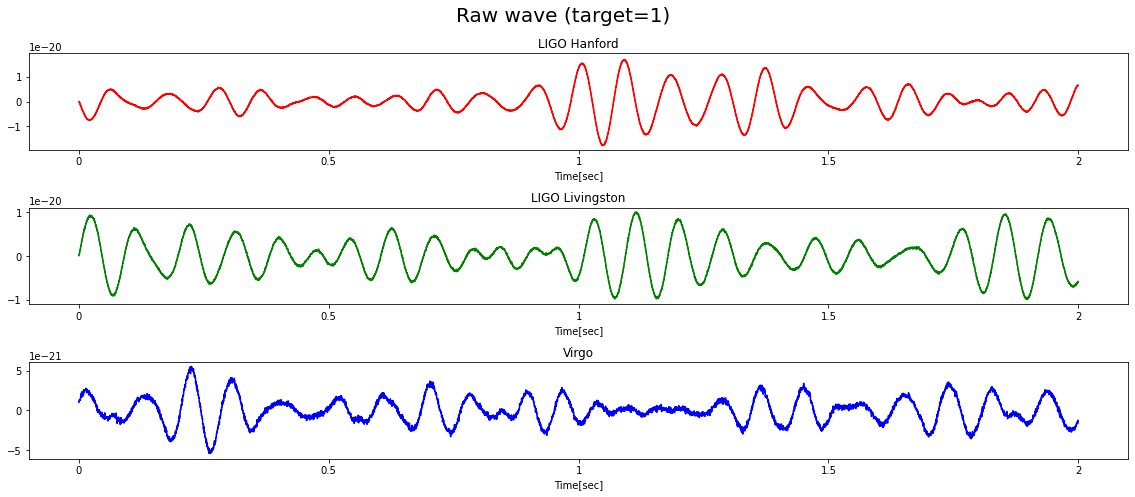

1it [00:00,  1.44it/s]

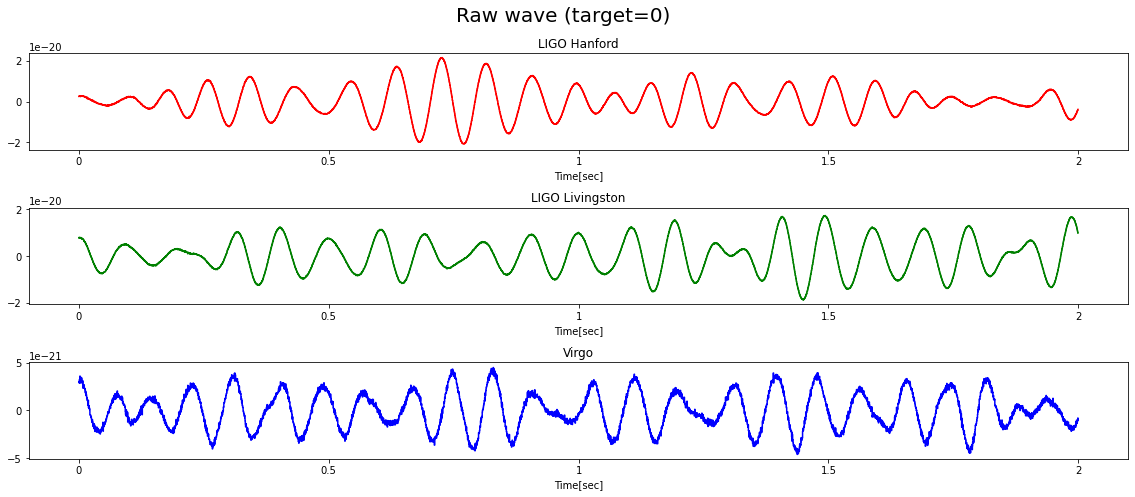

2it [00:01,  1.43it/s]


In [19]:
colors = ("red", "green", "blue")
signal_names = ("LIGO Hanford", "LIGO Livingston", "Virgo")

for x, i in tqdm(zip(samples, targets)):
    figure = plt.figure(figsize=(16, 7))
    figure.suptitle(f'Raw wave (target={i})', fontsize=20)
    # range is 3 because we have 3 different rows for each interferometers
    for j in range(3):
        axes = figure.add_subplot(3, 1, j+1)
        librosa.display.waveshow(x[j], sr=2048, ax=axes, color=colors[j])
        axes.set_title(signal_names[j], fontsize=12)
        axes.set_xlabel('Time[sec]')
    plt.tight_layout()
    plt.show()

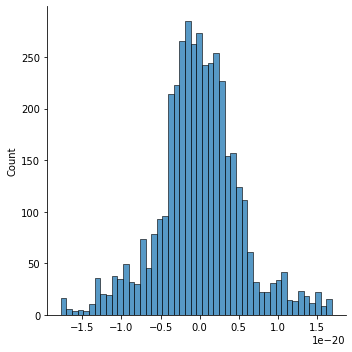

In [20]:
sns.displot(positive_sample[0,:])

## Working with a cleaner datset by merging `train` and `training_labels` datasets

In [21]:
pd.set_option('display.max_colwidth',None)

In [22]:
ids = []
for files in train_path:
    ids.append(files[files.rindex('/')+1:].replace('.npy',''))
df = pd.DataFrame({"id":ids,"path":train_path})
df = pd.merge(df, train_label_dataset, on='id')

In [23]:
df.head()

,id,path,target
0,777d746e90,../input/g2net-gravitational-wave-detection/train/7/7/7/777d746e90.npy,1
1,777ecfbd65,../input/g2net-gravitational-wave-detection/train/7/7/7/777ecfbd65.npy,0
2,7770956992,../input/g2net-gravitational-wave-detection/train/7/7/7/7770956992.npy,1
3,77727f6826,../input/g2net-gravitational-wave-detection/train/7/7/7/77727f6826.npy,1
4,777c84c377,../input/g2net-gravitational-wave-detection/train/7/7/7/777c84c377.npy,0


In [24]:
df.shape

(560000, 3)

# Preprocessing

#### Core Idea: 
If any particular frequency is widespread in the signal or not. If true then our required GW is present.

Approach:

- convert original signal  -->  spectrogram signal
- coverting from time domain  --> frequency domain
    - done using **[Constant Q transformation](https://en.wikipedia.org/wiki/Constant-Q_transform)**
    - **[kernel](https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration/comments)**


I refer to the kernel [here](https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration/comments) to define my CQT.

Please have a look. 

In [25]:
# CQT
transform = CQT1992v2(sr=2048,        # sample rate
                fmin=20,        # min freq
                fmax=500,      # max freq
                hop_length=64,  # hop length
                verbose=False)

In [26]:
# the Cqt function
# preprocess function
def preprocess_function_cqt(path):
    signal = np.load(path.numpy())
    # there are 3 signal as explained before for each interferometers
    for i in range(signal.shape[0]):
        # normalize signal
        signal[i] /= np.max(signal[i])
    # horizontal stack
    signal = np.hstack(signal)
    # tensor conversion
    signal = torch.from_numpy(signal).float()
    # getting the image from CQT transform
    image = transform(signal)
    # converting to array from tensor
    image = np.array(image)
    # transpose the image to get right orientation
    image = np.transpose(image,(1,2,0))
    
    # conver the image to tf.tensor and return
    return tf.convert_to_tensor(image)

(56, 193, 1)


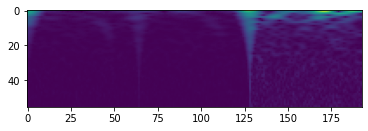

In [27]:
image = preprocess_function_cqt(tf.convert_to_tensor(df['path'][2]))
print(image.shape)
plt.imshow(image)

for a different path

(56, 193, 1)


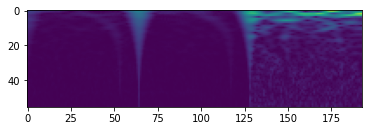

In [28]:
image = preprocess_function_cqt(tf.convert_to_tensor(df['path'][5069]))
print(image.shape)
plt.imshow(image)

we can see that the image shape is **(56, 193, 1)**, so thats our shpa eof the input.

In [29]:
input_shape = (56, 193, 1)

In [30]:
def preprocess_function_parse_tf(path, y=None):
    [x] = tf.py_function(func=preprocess_function_cqt, inp=[path], Tout=[tf.float32])
    x = tf.ensure_shape(x, input_shape)
    if y is None:
        return x
    else:
        return x,y

In [31]:
# preprocess_function_parse_tf(tf.convert_to_tensor(df['path'][5069]))

### I will define the `training` and `validation` dataset from `df`

In [32]:
X = df['id']
y = df['target'].astype('int8').values

In [33]:
y

array([1, 0, 1, ..., 1, 1, 0], dtype=int8)

In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, stratify = y)

In [35]:
batch_size = 250

In [36]:
def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'../input/g2net-gravitational-wave-detection/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        return f'../input/g2net-gravitational-wave-detection/test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train.apply(get_npy_filepath).values, y_train))
# shuffle the dataset
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [38]:
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid.apply(get_npy_filepath).values, y_valid))
valid_dataset = valid_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [39]:
train_dataset

<PrefetchDataset shapes: ((None, 56, 193, 1), (None,)), types: (tf.float32, tf.int8)>

In [40]:
valid_dataset

<PrefetchDataset shapes: ((None, 56, 193, 1), (None,)), types: (tf.float32, tf.int8)>

# Creating the Model

In [41]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 56, 193, 1), (None,)), types: (tf.float32, tf.int8)>

Model from [here](https://github.com/SiddharthPatel45/gravitational-wave-detection/blob/main/code/gw-detection-modelling.ipynb) ~

In [42]:
# Instantiate the Sequential model
model_cnn = Sequential(name='CNN_model')

# Add the first Convoluted2D layer w/ input_shape & MaxPooling2D layer followed by that
model_cnn.add(Conv2D(filters=16,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_01'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_01'))

# Second pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=32,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_02'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_02'))

# Third pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=64,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_03'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_03'))

# Add the Flatten layer
model_cnn.add(Flatten(name='Flatten'))

# Add the Dense layers
model_cnn.add(Dense(units=512,
                activation='relu',
                name='Dense_01'))
model_cnn.add(Dense(units=64,
                activation='relu',
                name='Dense_02'))

# Add the final Output layer
model_cnn.add(Dense(1, activation='sigmoid', name='Output'))

In [43]:
model_cnn.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_01 (Conv2D)             (None, 54, 191, 16)       160       
_________________________________________________________________
Pool_01 (MaxPooling2D)       (None, 27, 95, 16)        0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 25, 93, 32)        4640      
_________________________________________________________________
Pool_02 (MaxPooling2D)       (None, 12, 46, 32)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 10, 44, 64)        18496     
_________________________________________________________________
Pool_03 (MaxPooling2D)       (None, 5, 22, 64)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 7040)              0 

In [44]:
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

In [45]:
# Fit the data
history_cnn = model_cnn.fit(x=train_dataset,
                            epochs=3,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            verbose=1)

2021-09-16 10:19:59.250390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 10:19:59.254787: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/3


2021-09-16 10:20:00.072237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-16 10:20:00.995209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-16 10:20:02.343096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1680/1680 [==============================] - 3060s 2s/step - loss: 0.5705 - auc: 0.7459 - accuracy: 0.6755 - val_loss: 0.4881 - val_auc: 0.8292 - val_accuracy: 0.7517
Epoch 2/3
1680/1680 [==============================] - 3111s 2s/step - loss: 0.4868 - auc: 0.8240 - accuracy: 0.7527 - val_loss: 0.4931 - val_auc: 0.8337 - val_accuracy: 0.7477
Epoch 3/3
1680/1680 [==============================] - 3148s 2s/step - loss: 0.4813 - auc: 0.8279 - accuracy: 0.7568 - val_loss: 0.4761 - val_auc: 0.8362 - val_accuracy: 0.7599


saving the model after training is complete

In [46]:
model_cnn.save('./model/cnn_model.h5')

In [47]:
ls -a ./

./  ../  __notebook__.ipynb  model/


# Preprocessing Test 

In [48]:
ls -a ../input/g2net-gravitational-wave-detection/sample_submission.csv

../input/g2net-gravitational-wave-detection/sample_submission.csv


assigning submission ids to the test set to make prediction on them

In [49]:
sub = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
x_test = sub[['id']]

In [50]:
x_test.tail()

,id
225995,ffff4125f1
225996,ffff9d32a6
225997,ffff9f4c1f
225998,ffffa19693
225999,ffffebbfe2


In [51]:
# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test['id'].apply(get_npy_filepath, is_train=False).values))
test_dataset = test_dataset.map(preprocess_function_parse_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [52]:
test_dataset

<PrefetchDataset shapes: (None, 56, 193, 1), types: tf.float32>

# Prediction

Now, we will load the cnn model that we saved after training to make prediction on `test_dataset`

In [53]:
ls -a ./model/

./  ../  cnn_model.h5


In [54]:
saved_cnn_model = tf.keras.models.load_model('./model/cnn_model.h5')

In [55]:
saved_cnn_model

retraining the saved model on `valid_dataset`

> previously we set x = train_dataset

In [56]:
saved_cnn_model.fit(x=valid_dataset, epochs=3, batch_size=batch_size, verbose=1)

Epoch 1/3
560/560 [==============================] - 803s 1s/step - loss: 0.4748 - auc: 0.8332 - accuracy: 0.7614
Epoch 2/3
560/560 [==============================] - 789s 1s/step - loss: 0.4732 - auc: 0.8343 - accuracy: 0.7622
Epoch 3/3
560/560 [==============================] - 795s 1s/step - loss: 0.4721 - auc: 0.8351 - accuracy: 0.7624


Now saving the full model after training to make prediction on `test_dataset`

In [57]:
saved_cnn_model.save('./model/full_cnn_model.h5')

In [58]:
full_cnn_model = tf.keras.models.load_model('./model/full_cnn_model.h5')

In [59]:
prediction = full_cnn_model.predict(test_dataset)

In [60]:
prediction

array([[0.9999392 ],
       [0.73540634],
       [0.25192785],
       ...,
       [0.2072532 ],
       [0.9596004 ],
       [0.07191069]], dtype=float32)

In [61]:
prediction = prediction.flatten()

# Preparing to Submit

In [62]:
submission = pd.DataFrame({'id': x_test.id, 'target': prediction})

In [63]:
submission.shape

(226000, 2)

In [64]:
submission.head()

,id,target
0,00005bced6,0.999939
1,0000806717,0.735406
2,0000ef4fe1,0.251928
3,00020de251,0.336016
4,00024887b5,0.188438


In [65]:
submission.to_csv('./submission.csv', index= False)

I started with zero idea and I ended up learning about a lot of new things. I am very much thankful to all these resources that help me increase my knowledge and give me more insight as I proceed to improve my skills on my coding journey.

I tried referencing as much as I could.